# Overview
- モデルをlightGBMにした
- 009からさらにfeatureを削ってみる

# Const

In [ ]:
path_X_tr = './../../Dataset-CareerCon-2019-Help-Navigate-Robots/Tutorial/data/X_train.csv'
path_y_tr = './../../Dataset-CareerCon-2019-Help-Navigate-Robots/Tutorial/data/y_train.csv'
path_X_te = './../../Dataset-CareerCon-2019-Help-Navigate-Robots/Tutorial/data/X_test.csv'

# Import everything I need :)

In [2]:
import sys
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import itertools
from fastprogress import progress_bar
sys.path.insert(0, './../../Dataset-CareerCon-2019-Help-Navigate-Robots/Tutorial/secret-data')
from tell_me_score import tell_me_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import librosa
import copy
import lightgbm as lgb

/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


# myfnuc

In [3]:
class permutation_importance():
    def __init__(self, model, metric):
        self.is_computed = False
        self.n_feat = 0
        self.base_score = 0
        self.model = model
        self.metric = metric
        self.df_result = []
    
    def compute(self, X_valid, y_valid):
        self.n_feat = len(X_valid.columns)
        if self.metric == 'auc':
            y_valid_score = self.model.predict_proba(X_valid)[:, 1]
            fpr, tpr, thresholds = roc_curve(y_valid, y_valid_score)
            self.base_score = auc(fpr, tpr)
        else:
            self.base_score = self.metric(y_valid, self.model.predict(X_valid))
        self.df_result = pd.DataFrame({'feat': X_valid.columns, 
                                       'score': np.zeros(self.n_feat),
                                       'score_diff': np.zeros(self.n_feat)})
        
        # predict
        for i, col in enumerate(X_valid.columns):
            df_perm = X_valid.copy()
            np.random.seed(1)
            df_perm[col] = np.random.permutation(df_perm[col])
            y_valid_pred = self.model.predict(df_perm)
            if self.metric == 'auc':
                y_valid_score = self.model.predict_proba(df_perm)[:, 1]
                fpr, tpr, thresholds = roc_curve(y_valid, y_valid_score)
                score = auc(fpr, tpr)
            else:
                score = self.metric(y_valid, y_valid_pred)
            self.df_result['score'][self.df_result['feat']==col] = score
            self.df_result['score_diff'][self.df_result['feat']==col] = self.base_score - score
        self.is_computed = True
    
    def get_negative_feature(self):
        assert self.is_computed!=False, 'compute メソッドが実行されていません'
        idx = self.df_result['score_diff'] < 0
        return self.df_result.loc[idx, 'feat'].values.tolist()
        
    def get_positive_feature(self):
        assert self.is_computed!=False, 'compute メソッドが実行されていません'
        idx = self.df_result['score_diff'] > 0
        return self.df_result.loc[idx, 'feat'].values.tolist()
    
    def show_permutation_importance(self, score_type='loss'):
        '''score_type = 'loss' or 'accuracy'  '''
        assert self.is_computed!=False, 'compute メソッドが実行されていません'
        if score_type=='loss':
            ascending = True
        elif score_type=='accuracy':
            ascending = False
        else:
            ascending = ''
        
        plt.figure(figsize=(15, int(0.25*self.n_feat)))
        sns.barplot(x="score_diff", y="feat", data=self.df_result.sort_values(by="score_diff", ascending=ascending))
        plt.title('base_score - permutation_score')

In [4]:
def plot_confusion_matrix(truth, pred, classes, normalize=False, title=''):
    cm = confusion_matrix(truth, pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix', size=15)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)
    plt.tight_layout()

# Preparation

set

In [5]:
sns.set()
warnings.filterwarnings('ignore')

<br>

load data

In [6]:
df_X = pd.read_csv(path_X_tr)
df_y = pd.read_csv(path_y_tr)

df_X_te = pd.read_csv(path_X_te)

<br>

label encoding

In [7]:
le = LabelEncoder()
le.fit(df_y['surface'].values)
y = le.transform(df_y['surface'].values)

In [8]:
y.shape

(2667,)

# EDA

In [9]:
df_X.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,1_0,1,0,-0.95896,0.24074,0.030758,-0.14661,0.283420,0.002192,-0.050810,2.18480,2.25260,-8.9503
1,1_1,1,1,-0.95890,0.24079,0.030786,-0.14693,0.108930,-0.009485,0.009155,0.49905,2.97620,-5.4953
2,1_2,1,2,-0.95889,0.24076,0.030807,-0.14702,-0.073197,0.003959,-0.023384,0.74827,1.68030,-7.3061
3,1_3,1,3,-0.95888,0.24076,0.030742,-0.14712,-0.064979,0.068265,0.018673,1.84080,0.22349,-11.4910
4,1_4,1,4,-0.95888,0.24079,0.030707,-0.14702,0.077929,0.005519,0.022119,-0.49667,-0.92942,-12.2980


<br>

特徴量作成
- 1series_id 1特徴量にしなければならない
- 今回は、`series_id` ごとに平均値を出してみた

In [10]:
feat_names = ['orientation_X', 'orientation_Y', 'orientation_Z', 
              'orientation_W', 'angular_velocity_X', 'angular_velocity_Y', 'angular_velocity_Z', 
              'linear_acceleration_X', 'linear_acceleration_Y', 'linear_acceleration_Z']

In [11]:
# groupbyをつかって `series_id` 毎に平均値を作成
X = df_X.groupby('series_id')[feat_names].mean()
X_te = df_X_te.groupby('series_id')[feat_names].mean()

In [12]:
X.head()

,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
series_id,,,,,,,,,,
1,-0.958606,0.241867,0.031650,-0.146876,0.004605,-0.007757,0.006206,0.121867,2.768193,-9.388899
3,-0.939169,0.310140,0.038955,-0.142319,0.000624,-0.002804,0.007887,0.201791,2.657922,-9.451164
4,-0.891301,0.428144,0.060056,-0.136460,0.006969,0.046109,-0.142385,-0.086171,2.981498,-9.349988
5,0.464712,-0.872496,-0.127264,0.081212,-0.007366,-0.000134,-0.006881,0.109911,2.668945,-9.285242
6,-0.402356,-0.903141,-0.140541,-0.051849,0.010419,0.017725,-0.050957,0.175171,2.640550,-9.465020


In [13]:
# 標準偏差も入れてみる
X_var = df_X.groupby('series_id')[feat_names].std()
X_var_te = df_X_te.groupby('series_id')[feat_names].std()
feat_names_var = X_var.columns
feat_names_var = [ name + "_var" for name in feat_names_var ]
X_var.columns = feat_names_var
X_var_te.columns = feat_names_var

In [14]:
X_var.head()

,orientation_X_var,orientation_Y_var,orientation_Z_var,orientation_W_var,angular_velocity_X_var,angular_velocity_Y_var,angular_velocity_Z_var,linear_acceleration_X_var,linear_acceleration_Y_var,linear_acceleration_Z_var
series_id,,,,,,,,,,
1,0.000151,0.000499,0.000508,0.000521,0.092309,0.046523,0.067533,1.105945,1.864457,2.123065
3,0.000227,0.000453,0.000449,0.001371,0.179544,0.046700,0.032265,1.472019,4.201410,3.478530
4,0.002955,0.006165,0.000985,0.000541,0.044773,0.016114,0.038489,0.437707,1.137776,0.812585
5,0.000315,0.000225,0.000658,0.000376,0.098252,0.055027,0.052613,1.544754,2.280124,2.280960
6,0.002120,0.001013,0.000318,0.000557,0.025530,0.011644,0.015867,0.449003,0.671358,0.496206


In [15]:
X_var_te.head()

,orientation_X_var,orientation_Y_var,orientation_Z_var,orientation_W_var,angular_velocity_X_var,angular_velocity_Y_var,angular_velocity_Z_var,linear_acceleration_X_var,linear_acceleration_Y_var,linear_acceleration_Z_var
series_id,,,,,,,,,,
0,0.000363,0.000471,0.000432,0.000389,0.052800,0.031544,0.017127,0.911175,1.387790,1.095040
2,0.001377,0.000785,0.000541,0.000278,0.060168,0.035530,0.021866,0.756138,1.769792,1.140267
9,0.021568,0.028636,0.004359,0.003011,0.083914,0.064916,0.035946,1.702722,1.927859,2.137469
10,0.000878,0.001494,0.000368,0.000555,0.048430,0.039834,0.028673,1.184800,1.217480,1.123871
13,0.003819,0.001530,0.000668,0.001280,0.053344,0.046725,0.032170,1.408443,1.004574,1.330694


In [16]:
# featureをどんどん追加してみる
feat_names = ['angular_velocity_X', 'angular_velocity_Y', 'angular_velocity_Z', 
              'linear_acceleration_X', 'linear_acceleration_Y', 'linear_acceleration_Z']
series_id_list = df_X['series_id'].unique()

In [17]:
# yy = df_X[df_X['series_id']==series_id][feat_name].values
# df_X[df_X['series_id']==1]

In [18]:
df_new = pd.DataFrame( columns=['series_id',
                                  'angular_velocity_X_flatness'   ,'angular_velocity_Y_flatness'   ,'angular_velocity_Z_flatness',
                                 'linear_acceleration_X_flatness','linear_acceleration_Y_flatness','linear_acceleration_Z_flatness',
                               ] )


sr = 0.1
for series_id in series_id_list:
# for series_id in series_id_list[:3]:
    
    new_feat_val_list = [int(series_id)]

    for feat_name in feat_names:
    # flatness
        yy = df_X[df_X['series_id']==series_id][feat_name].values
        val = librosa.feature.spectral_flatness(y=yy, n_fft=128)
        new_feat_val_list.append(val[0][0])
    tmp_se = pd.Series( new_feat_val_list, index=df_new.columns )
    df_new = df_new.append( tmp_se, ignore_index=True )    

In [19]:
df_new.head()

,series_id,angular_velocity_X_flatness,angular_velocity_Y_flatness,angular_velocity_Z_flatness,linear_acceleration_X_flatness,linear_acceleration_Y_flatness,linear_acceleration_Z_flatness
0,1.0,0.021054,0.143648,0.018275,0.342903,0.090136,0.007601
1,3.0,0.003986,0.135348,0.064265,0.103396,0.032772,0.021691
2,4.0,0.025663,0.011721,0.000594,0.073131,0.001469,0.000331
3,5.0,0.047184,0.094430,0.040432,0.177096,0.028791,0.004933
4,6.0,0.096968,0.034350,0.002099,0.153979,0.004421,0.000213


---

<font color='orange'>**series_id が特徴量として聞く理由を探ってみる**</font>

In [20]:
series_id = df_y['series_id'].values

In [21]:
le.inverse_transform([0])

array(['carpet'], dtype=object)

<br>

surfaceごとのseries_idのkde

Text(0.5, 0, 'id')

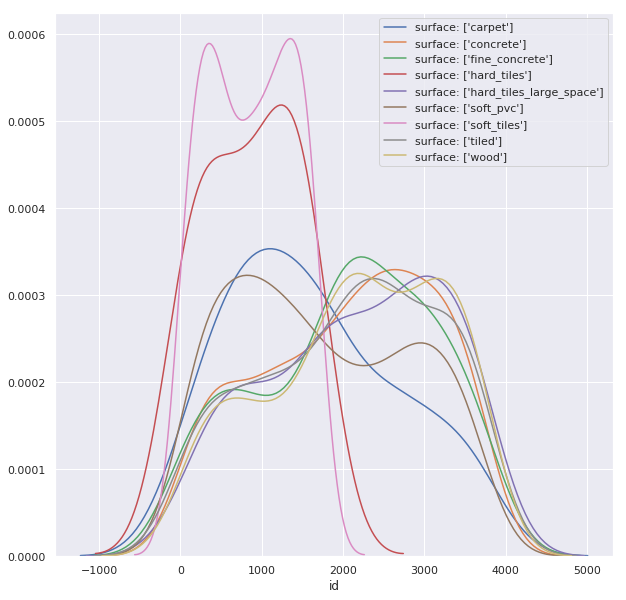

In [22]:
fig, ax = plt.subplots(figsize=(10, 10))
for class_ in np.unique(y):
    idxs = y == class_
    series_id_class = series_id[idxs]
    sns.kdeplot(series_id_class, ax=ax, label=f'surface: {le.inverse_transform([class_])}')
ax.set_xlabel('id')

> soft_tiles と、hard_tiles はseries_id 低めとなっている。  ただ、submissionのデータセットでもそうなってるかはわからない。  
あ、久保田がtrainのデータ・セットから作ったから、そうなってる可能性が高いか...

---

In [23]:
series_id_list_te = df_X_te['series_id'].unique()

In [24]:
df_new_te = pd.DataFrame( columns=['series_id',
                                  'angular_velocity_X_flatness'   ,'angular_velocity_Y_flatness'   ,'angular_velocity_Z_flatness',
                                 'linear_acceleration_X_flatness','linear_acceleration_Y_flatness','linear_acceleration_Z_flatness',
                               ] )


sr = 0.1
for series_id in series_id_list_te:
    
    new_feat_val_list_te = [int(series_id)]

    for feat_name in feat_names:
    # flatness
        yy = df_X_te[df_X_te['series_id']==series_id][feat_name].values
        val = librosa.feature.spectral_flatness(y=yy, n_fft=128)
        new_feat_val_list_te.append(val[0][0])
    tmp_se_te = pd.Series( new_feat_val_list_te, index=df_new_te.columns )
    
    df_new_te = df_new_te.append( tmp_se_te, ignore_index=True )    

df_new['series_id'] = df_new['series_id'].astype(np.int64)
df_new_te['series_id'] = df_new_te['series_id'].astype(np.int64)

<br>

merge

In [27]:
X_plus = pd.merge(X,X_var,on='series_id')
X_plus = pd.merge(X_plus,df_new,on='series_id')

X_plus_te = pd.merge(X_te,X_var_te,on='series_id')
X_plus_te = pd.merge(X_plus_te,df_new_te,on='series_id')

#X_te_plus_v = pd.merge(X_te,X_plus_te,on='series_id')

<font color='yellow'> **↑ これ、だめです。標準化の値をテストデータとtrainデータで分けるのは。やるなら、trainで作ったscをtrainとtestに使うとかです。そもそも、決定木系なので標準化意味ないのですが。** </font>

In [28]:
X_plus_std = X_plus
X_plus_std_te = X_plus_te

In [29]:
print('count')
print(f'n_df_X: {len(df_X)}')
print(f'   n_X: {len(X)}')
print(f'   n_X__var: {len(X_plus_std)}')
print(f'   n_y: {len(y)}')

count
n_df_X: 341376
   n_X: 2667
   n_X__var: 2667
   n_y: 2667


## train and evaluation

<br>

train validation split  
(本当は、クロスバリデーションがいい。)

In [133]:
X_plus_std.columns

Index(['series_id', 'orientation_X', 'orientation_Y', 'orientation_Z',
       'orientation_W', 'angular_velocity_X', 'angular_velocity_Y',
       'angular_velocity_Z', 'linear_acceleration_X', 'linear_acceleration_Y',
       'linear_acceleration_Z', 'orientation_X_var', 'orientation_Y_var',
       'orientation_Z_var', 'orientation_W_var', 'angular_velocity_X_var',
       'angular_velocity_Y_var', 'angular_velocity_Z_var',
       'linear_acceleration_X_var', 'linear_acceleration_Y_var',
       'linear_acceleration_Z_var', 'angular_velocity_X_flatness',
       'angular_velocity_Y_flatness', 'angular_velocity_Z_flatness',
       'linear_acceleration_X_flatness', 'linear_acceleration_Y_flatness',
       'linear_acceleration_Z_flatness'],
      dtype='object')

In [30]:
# オプションにstratify入れてるのもポイント
X_tr, X_va, y_tr, y_va = train_test_split(X_plus_std, y, test_size=0.33, random_state=42, stratify=y)

<br>

lightgbmは以下を参考にしてください。
> https://github.com/fkubota/notebook/blob/master/12_lightGBM.ipynb

In [127]:
model = lgb.LGBMClassifier(objective='multiclass',  
                           num_leaves=100,
                           max_depth=100, 
                           learning_rate=0.05,
                           min_child_samples=10,
                           colsample_bytree=0.5,
                           random_state=42,
                           n_estimators=1000)
result = model.fit(X_tr, y_tr,
                   eval_set=[(X_tr, y_tr), (X_va, y_va)],
                   #eval_metric='multi_logloss',
                   verbose=30,
                   early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds
[30]	training's multi_logloss: 0.47527	valid_1's multi_logloss: 0.788234
[60]	training's multi_logloss: 0.149893	valid_1's multi_logloss: 0.501039
[90]	training's multi_logloss: 0.0483937	valid_1's multi_logloss: 0.392759
[120]	training's multi_logloss: 0.015972	valid_1's multi_logloss: 0.352929
[150]	training's multi_logloss: 0.00533099	valid_1's multi_logloss: 0.339329
[180]	training's multi_logloss: 0.00180257	valid_1's multi_logloss: 0.340595
[210]	training's multi_logloss: 0.000608933	valid_1's multi_logloss: 0.347745
[240]	training's multi_logloss: 0.000208752	valid_1's multi_logloss: 0.360601
Early stopping, best iteration is:
[166]	training's multi_logloss: 0.00297506	valid_1's multi_logloss: 0.338129


<font color='yellow'>**パラメータ見た感じ、min_child_samplesとcolsample_bytreeが効きそうです。おそらく、データのレコード数が極端に少ないクラスがあるためです。モデルの仕組みを理解していると、パラメータの調整もある程度調整できます。**</font>

In [128]:
pred_tr = model.predict(X_tr, num_iteration=model.best_iteration_)
pred_va = model.predict(X_va, num_iteration=model.best_iteration_)

<font color='yellow'>**↑ベストイテレーションのパラム使わないとearly_stoping_roundsの意味がないです**</font>

<br>

evaluatoin
- score

In [129]:
print(f'accurady train: {accuracy_score(y_tr, pred_tr):.3f}')
print(f'accurady valid: {accuracy_score(y_va, pred_va):.3f}')

accurady train: 1.000
accurady valid: 0.898


<br>

- confusin_matlix

<br>

- permutation importance

> https://github.com/fkubota/LightningTalk/blob/master/003_permutation_importance/LT_permutation_importance.ipynb

# Submission
- 作成したモデルでテストデータを評価する

In [130]:
pred_te = model.predict(X_plus_std_te)

In [131]:
submission = pd.DataFrame(df_X_te['series_id'].unique(), columns=['series_id'])
submission['surface'] = le.inverse_transform(pred_te)

<br>

submission data を渡す

In [132]:
accuracy = tell_me_score(submission)
print(f'accuracy score:{accuracy :.3f}')

accuracy score:0.903


In [113]:
# zcr 追加 0.748 → 0.756
# centroid 追加 0.761 → 0.773
# bandwidth 追加 0.767 → 0.770
# flatness 追加 0.716 → 0.781
# rolloff 追加 0.766　→ 0.757
# lpc 追加 0.701